In [1]:
# 将错误图片信息写入xlsx文件中
import os
from PIL import Image
from tqdm import tqdm
import pandas as pd 

data_root = '/data/wsi/TCTGC50k/TCTGC50k-volume1/'

wsi_names = ['T202234673', 'T202234666', 'T202329508', 'test0001', 'T202232995', 'M202331996']
error_df = 'tct_img_error2.xlsx'
volume_num = 1
if os.path.exists(error_df):
    df = pd.read_excel(error_df)
else:
    df = pd.DataFrame(columns=['wsi_name', 'img_name', 'volume'])
for wsi_name in wsi_names:
    img_files = os.listdir(os.path.join(data_root, wsi_name))
    for img_file in tqdm(img_files):
        try:
            img_path = os.path.join(data_root, wsi_name, img_file)
            img = Image.open(img_path)
            img.resize((224, 224))
        except:
            new_row = pd.DataFrame({'wsi_name': [wsi_name], 'img_name': [img_file], 'volume': [volume_num]})
            df = pd.concat([df, new_row], ignore_index=True)
df.to_excel(error_df, index=False)

100%|██████████| 442/442 [01:33<00:00,  4.73it/s]


# 统计一张WSI的像素信息 并 拼接WSI成一张图片 


patch num: (23, 33), total hight: 94208, total width: 92928
total pixels: 8.754561024 billion, total size: 24.4599609375 GB


0it [00:00, ?it/s]

759it [02:46,  4.55it/s]


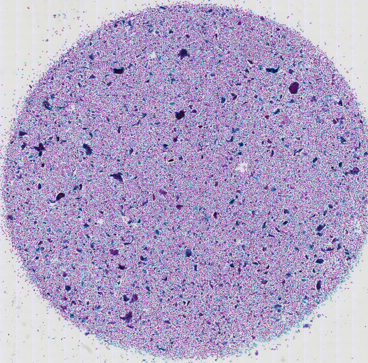

In [8]:
import os
from PIL import Image
from tqdm import tqdm

data_root = '/data/wsi/TCTGC50k/TCTGC50k-volume1'
wsi_name = '005201531-N'
wsi_dir  = os.path.join(data_root, wsi_name)
# wsi_dir = '/home/huangjialong/projects/BiomedCLIP-PUNCE/test/test_img' # for debug
imgfiles = os.listdir(wsi_dir)
xs, ys = [int(imgfile.split('.')[0].split('_')[0]) for imgfile in imgfiles], \
            [int(imgfile.split('.')[0].split('_')[1]) for imgfile in imgfiles]
x_max, y_max = max(xs), max(ys)
print('patch num: ({}, {}), total hight: {}, total width: {}'.format(x_max, y_max, x_max*4096, y_max*2816))
print('total pixels: {} billion, total size: {} GB'.format(x_max * y_max * 4096 * 2816 / (10**9),\
            x_max * y_max * 4096 * 2816 * 3 / (1024**3))) 

# 列出所有符合条件的图像文件
x_max, y_max
# 计算每个子图的大小

img_width, img_height = 4096, 2816
resize_ratio = 256
patch_resize_x, patch_resize_y = img_width//resize_ratio, img_height//resize_ratio
# 创建一个新的空白图像
total_width = patch_resize_x * x_max
total_height = patch_resize_y * y_max
combined_img = Image.new('RGB', (total_width, total_height))

# 将每张图像粘贴到新图像的适当位置
for i, file in tqdm(enumerate(imgfiles)):
    img = Image.open(os.path.join(wsi_dir, file))
    img = img.resize((patch_resize_x, patch_resize_y))
    x, y = int(file.split('.')[0].split('_')[0]), int(file.split('.')[0].split('_')[1])
    left = (x-1) * patch_resize_x
    upper = (y-1) * patch_resize_y
    combined_img.paste(img, (left, upper))

# 显示拼接后的图像
combined_img.show()

# 筛选出gc-2625中的HSIL，并保存缩略图

In [7]:
import os
from PIL import Image
import pandas as pd

input_path = '/home/huangjialong/projects/BiomedCLIP-PUNCE/datatools/gc/n-labels/all_label.csv'
df = pd.read_csv(input_path, header=None)
labels = []
hsil_wsi = []
for item in df.values:
    wsi_name, label = item[0], item[1]
    if label == 4:
        hsil_wsi.append(wsi_name)
print(hsil_wsi)

['CX20164770-HSIL+T', 'CX20146862-HSIL', 'CX20163889-HSIL', 'CX20165370-HSIL', 'xCR20018625-HSIL', '210105160955-4-2-HSIL', 'xCY20010730-HSIL', 'CX20165068-HSIL', '201228130049-6-3-HSIL', 'CX20148400-HSIL', '201223171642-13-1-HSIL', 'CX20146097-HSIL', 'CX20165881-HSIL', '201222213825-17-5-HSIL', '201217144235-6-5-HSIL', 'CX20146766-HSIL', 'CX20168715-HSIL', 'CX20147296-HSIL', 'CX20147350-HSIL', 'CX20165490-HSIL', 'CX20168181-HSIL', '201226132328-23-3-HSIL', 'CX20168435-HSIL', 'CX20169565-HSIL', 'CX20168734-HSIL', '210105112157-20-1-HSIL', 'CX20169728-HSIL', 'CX20163946-HSIL', 'CX20163817-HSIL', 'CX20169545-HSIL', 'CX20147071-HSIL', 'CX20169685-HSIL', 'CX20145707-HSIL', '201223172955-14-3-HSIL']


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        if alpha is None:
            self.alpha = torch.ones(1)
        else:
            self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha[targets] * (1 - pt) ** self.gamma * CE_loss
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# 示例
inputs = torch.randn(10, 5)  # 假设有10个样本，5个类别
targets = torch.randint(0, 5, (10,)).long()  # 假设目标值为0到4
print(inputs, targets)
criterion = FocalLoss(alpha=torch.tensor([0.5, 1, 1, 1, 1]))
loss = criterion(inputs, targets)
print(loss)


tensor([[-1.5651e+00, -1.1296e-01, -6.7443e-01,  1.4910e-01, -6.9194e-01],
        [ 2.0531e+00,  2.2506e-01,  1.4640e+00, -1.1043e+00,  6.4417e-01],
        [ 4.4418e-01, -9.6318e-01, -7.5076e-01,  1.2302e+00, -1.7954e+00],
        [-8.2965e-02,  2.1287e-01,  7.9358e-01, -4.0147e-01, -4.4057e-01],
        [-1.6895e+00,  3.8480e-01, -8.3720e-01,  9.9871e-01, -5.1888e-01],
        [ 1.4458e-01,  8.6221e-01, -1.9810e-01,  2.0025e-01,  7.5764e-01],
        [ 4.1395e-01,  5.9750e-02,  5.9093e-01, -9.4521e-01, -5.1207e-01],
        [-3.8435e-01, -4.5613e-01,  1.8191e-01, -1.3608e-01, -5.2338e-01],
        [-2.4961e-01, -4.0247e-01, -5.9953e-02, -8.9554e-01,  1.0987e-03],
        [-1.0272e-01, -1.8106e+00, -1.0079e+00, -1.0825e+00, -1.6888e-01]]) tensor([4, 2, 3, 4, 3, 2, 1, 4, 2, 0])
tensor(0.9231)


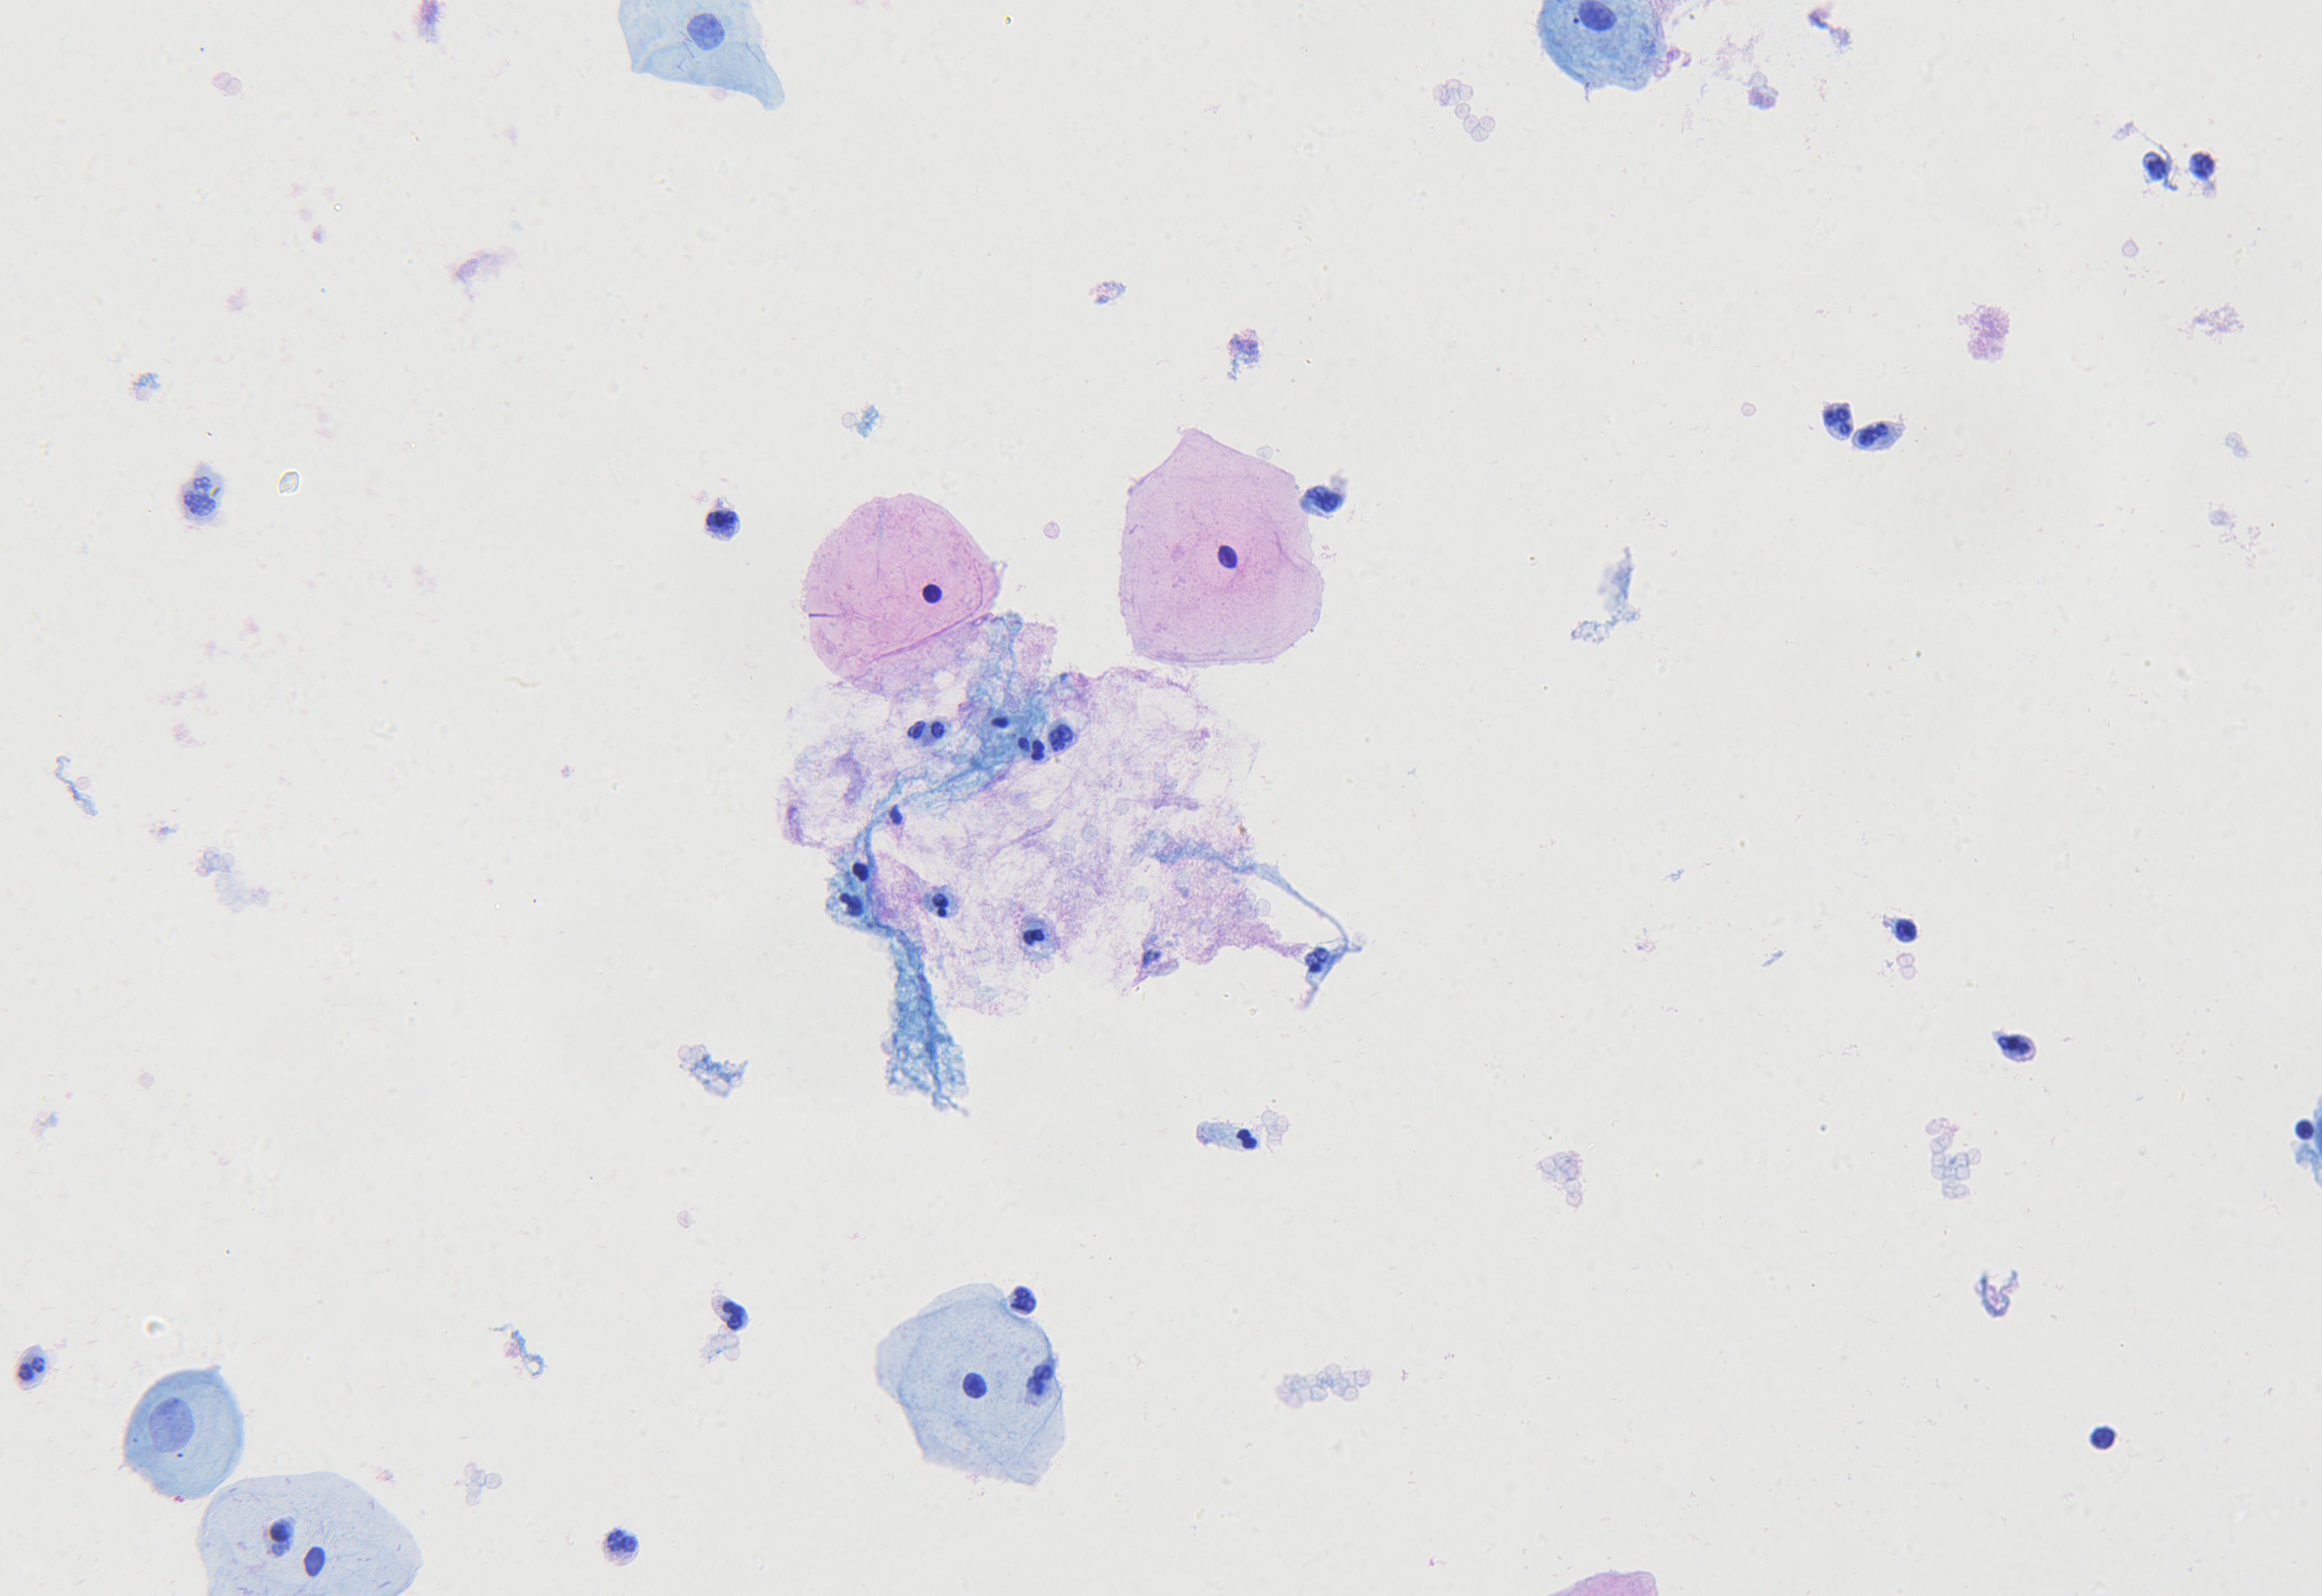

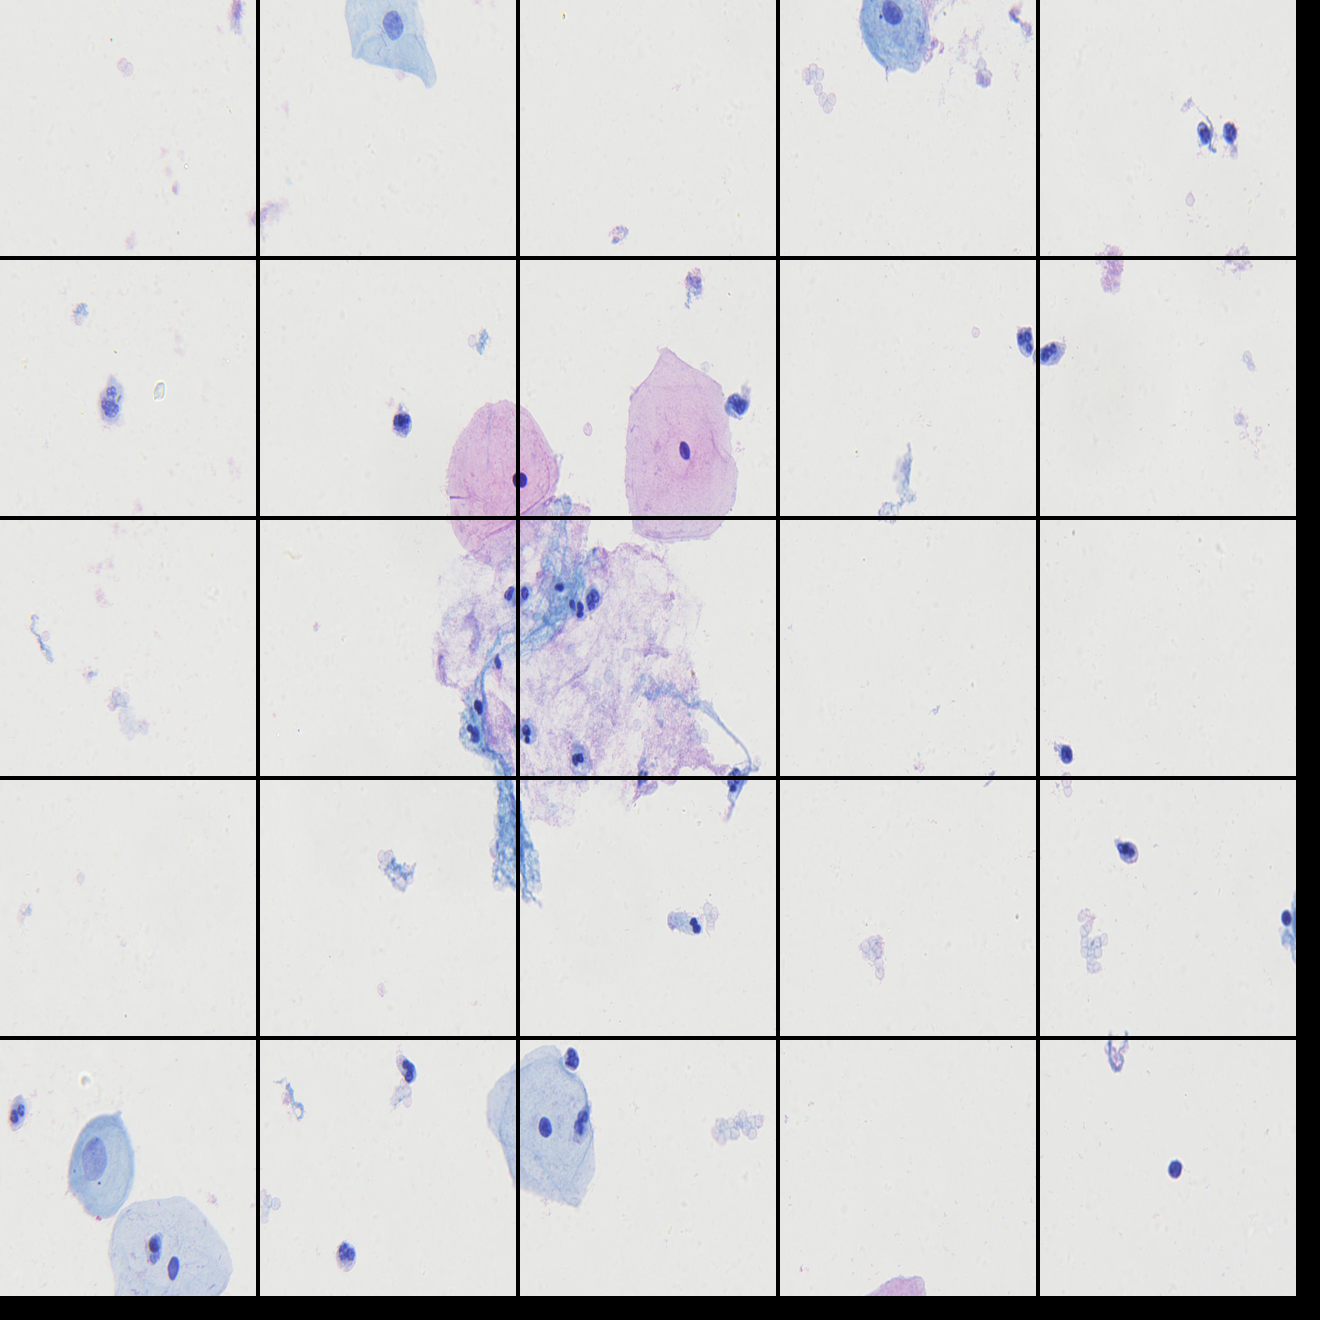

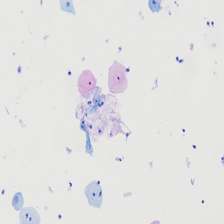

In [11]:
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt

def _crop_patchs(img, fine_grained_size):
        # crop patches from the image
        patches = []
        for j in range(0, img.size[1], fine_grained_size[1]):
            for i in range(0, img.size[0], fine_grained_size[0]): 
                patch = img.crop((i, j, i + fine_grained_size[0], j + fine_grained_size[1]))
                patches.append(patch)
        return patches
    
img_path = '2_17.jpg'
img = Image.open(img_path)
img.show()
fine_grained_pre_size=(1280,1280)
img = img.resize(fine_grained_pre_size)
fine_grained_size=(256,256)
# 切割后的图片
imgs = _crop_patchs(img, fine_grained_size)
cols, rows = 5, 5
total_width = (fine_grained_size[0]+8) * cols
total_height = (fine_grained_size[1]+8) * rows

# Create a new image with the correct size
grid_image = Image.new('RGB', (total_width, total_height))
# Paste each image into the grid
for i, _img in enumerate(imgs):
    row = i // cols
    col = i % cols
    grid_image.paste(_img, (col * (fine_grained_size[0]+4), row * (fine_grained_size[1]+4)))
grid_image.show()

target_patch_size=(224,224)
img.resize(target_patch_size).show()